In [33]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

import seaborn as sns
sns.set_style('white')

%matplotlib inline

In [4]:
sess = K.get_session()

In [5]:

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence*box_class_probs
    ### END CODE HERE ###
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores,axis=-1)
    box_class_scores = K.max(box_scores,axis=-1)
    ### END CODE HERE ###
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = box_class_scores>threshold
    ### END CODE HERE ###
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [6]:

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 7 lines)
    xi1 = np.max([box1_x1,box2_x1])
    yi1 = np.max([box1_y1,box2_y1])
    xi2 = np.min([box1_x2,box2_x2])
    yi2 = np.min([box1_y2,box2_y2])
    inter_width = xi2-xi1
    inter_height = yi2-yi1
    inter_area = np.max([inter_width,0]) * np.max([inter_height,0])
    ### END CODE HERE ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    union_area = box1_area + box2_area - inter_area
    ### END CODE HERE ###
    
    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area/union_area
    ### END CODE HERE ###
    
    return iou

In [7]:

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)
    ### END CODE HERE ###
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [8]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

## I am going to use transfer learning techniques for object detection tast

* The first step is to download the pre-trained model weights.These were trained using the DarkNet code base on the MSCOCO dataset. I have download the model weights and place them into my current working directory with the filename “yolov2.weights.”

* Next, we need to define a Keras model that has the right number and type of layers to match the downloaded model weights. The model architecture is called a “DarkNet” and was originally loosely based on the VGG-16 model. To do this we need to convert the Darknet YOLO_v2 model to a Keras model.

* And finally test the converted model on the small test set in images/.

**Details of doing these steps are provided at [this link](https://github.com/allanzelener/YAD2K)**


## run the following in the terminal to make the yolo.h5 

* wget http://pjreddie.com/media/files/yolo.weights
* wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolo.cfg
* ./yad2k.py yolo.cfg yolo.weights model_data/yolo.h5
* ./test_yolo.py model_data/yolo.h5  # output in images/out/

In [9]:
yolo_model = load_model("./yad2k/model_data/yolo.h5")


Instructions for updating:
Colocations handled automatically by placer.


/Users/mohammad/opt/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [11]:
class_names = read_classes("./yad2k/model_data/coco_classes.txt")
anchors = read_anchors("./yad2k/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)    

In [12]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

**I got many errors in the following part but by reordering the box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs in the yolo_eval compared to the previous code of NG solved the problem.**


In [13]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

In [29]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run(fetches=[scores,boxes ,classes]
                        ,feed_dict={yolo_model.input:image_data, K.learning_phase():0})
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("images/out", image_file), quality=90)
    # Display the results in the notebook
    output_image = matplotlib.pyplot.imread(os.path.join("images/out", image_file))
    imshow(output_image)
    
    return out_scores, out_boxes, out_classes

In [30]:
cd yad2k/

/Users/mohammad/Documents/Machin_learning/ino_proj/yad2k


In [31]:
from PIL import Image 

def img_reshape(image_name, width, height):
    img = Image.open('images/' + image_name)
    img = img.resize((width, height), Image.ANTIALIAS) 
    img.save('images/' + image_name)

(720, 1280, 3)
Found 2 boxes for truck.jpeg
truck 0.78 (60, 100) (975, 546)
person 0.79 (985, 289) (1210, 663)


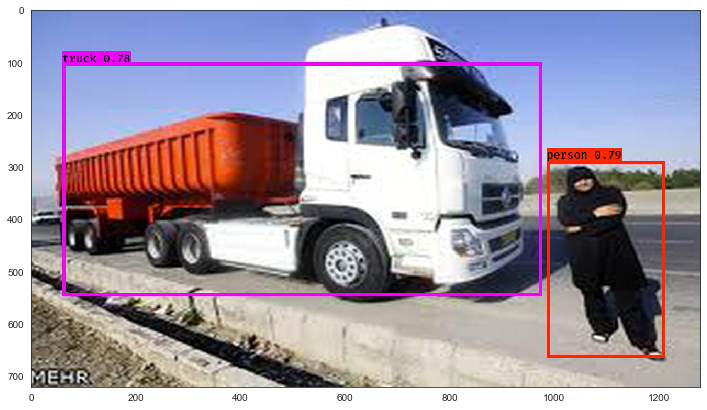

In [34]:
plt.figure(figsize=(12,8))
import matplotlib.pyplot
image_name = 'truck.jpeg'
img_reshape(image_name, 1280,720)
content_image = matplotlib.pyplot.imread("images/truck.jpeg")
print(content_image.shape)
imshow(content_image);
out_scores, out_boxes, out_classes = predict(sess, "truck.jpeg")